# **```Project Steps Overview```**

**```Step 1```: Gathering data**

**```Step 2```: Assessing data**

**```Step 3```: Cleaning data**

**```Step 4```: Storing data**

**```Step 5```: Analyzing, and visualizing data**

**```Step 6```: Reporting**
>* Data wrangling efforts <br>
>* Data analyses and visualizations

# Gathering Data

## Loading Data

In [1]:
# Importing neccessary packages (libraries) need
import pandas as pd
import numpy as np
import requests

import re
import os
import json
import time
import warnings

import matplotlib.pyplot as plt

import tweepy as tw
from tweepy import OAuthHandler

import json
from timeit import default_timer as def_timer

# from wordcloud import WordCloud
# from wordcloud import STOPWORDS

> ### Twitter Archive

In [2]:
#read the twitter archive file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# twitter_archive.head()

> ### Image predictions

In [4]:
#import the tweet image predictions using requests library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
#read the image predictions file
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')

In [5]:
# image_predictions.head()

> ### Twitter API and JSON

In [6]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'NPYMcRHJTB563d3fzdwScUyXl'
consumer_secret = 'FXU6Ytagx6ynVqsh0v80CSMHJyRqeYcNL2Cs4e7BE24kKkkURF'
access_token = '173892907-fa0YpmEv8V8vzjaErMhSI2tSvTtyZO2RwVkfdWgT'
access_secret = 'VlbWkcKVX0mkFl7lLv3V0Wp9nBvuwI3TEUPOkQ6cIpryg'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tw.API(auth)

 #### ``` HIDDEN TOKEN```

In [7]:
# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = tw.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tw.API(auth)

In [8]:
# lets extract the ids from the twitter_archive dataset
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [9]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = def_timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Successful")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tw.TweepyException as e:
            print("Failed")
            fails_dict[tweet_id] = e
            pass
end = def_timer()
print(end - start) 
print(fails_dict)

1: 892420643555336193
Successful
2: 892177421306343426
Successful
3: 891815181378084864
Successful
4: 891689557279858688
Successful
5: 891327558926688256
Successful
6: 891087950875897856
Successful
7: 890971913173991426
Successful
8: 890729181411237888
Successful
9: 890609185150312448
Successful
10: 890240255349198849
Successful
11: 890006608113172480
Successful
12: 889880896479866881
Successful
13: 889665388333682689
Successful
14: 889638837579907072
Successful
15: 889531135344209921
Successful
16: 889278841981685760
Successful
17: 888917238123831296
Successful
18: 888804989199671297
Successful
19: 888554962724278272
Successful
20: 888202515573088257
Failed
21: 888078434458587136
Successful
22: 887705289381826560
Successful
23: 887517139158093824
Successful
24: 887473957103951883
Successful
25: 887343217045368832
Successful
26: 887101392804085760
Successful
27: 886983233522544640
Successful
28: 886736880519319552
Successful
29: 886680336477933568
Successful
30: 886366144734445568
Succ

Successful
240: 846874817362120707
Successful
241: 846514051647705089
Successful
242: 846505985330044928
Successful
243: 846153765933735936
Successful
244: 846139713627017216
Successful
245: 846042936437604353
Successful
246: 845812042753855489
Successful
247: 845677943972139009
Successful
248: 845459076796616705
Failed
249: 845397057150107648
Successful
250: 845306882940190720
Successful
251: 845098359547420673
Successful
252: 844979544864018432
Successful
253: 844973813909606400
Successful
254: 844704788403113984
Failed
255: 844580511645339650
Successful
256: 844223788422217728
Successful
257: 843981021012017153
Successful
258: 843856843873095681
Successful
259: 843604394117681152
Successful
260: 843235543001513987
Successful
261: 842892208864923648
Failed
262: 842846295480000512
Successful
263: 842765311967449089
Successful
264: 842535590457499648
Successful
265: 842163532590374912
Successful
266: 842115215311396866
Successful
267: 841833993020538882
Successful
268: 8416805850305413

Successful
475: 816091915477250048
Successful
476: 816062466425819140
Successful
477: 816014286006976512
Successful
478: 815990720817401858
Successful
479: 815966073409433600
Successful
480: 815745968457060357
Successful
481: 815736392542261248
Successful
482: 815639385530101762
Successful
483: 815390420867969024
Successful
484: 814986499976527872
Successful
485: 814638523311648768
Successful
486: 814578408554463233
Successful
487: 814530161257443328
Successful
488: 814153002265309185
Successful
489: 813944609378369540
Successful
490: 813910438903693312
Successful
491: 813812741911748608
Successful
492: 813800681631023104
Successful
493: 813217897535406080
Successful
494: 813202720496779264
Successful
495: 813187593374461952
Successful
496: 813172488309972993
Successful
497: 813157409116065792
Successful
498: 813142292504645637
Successful
499: 813130366689148928
Successful
500: 813127251579564032
Successful
501: 813112105746448384
Successful
502: 813096984823349248
Successful
503: 8130

Successful
710: 785170936622350336
Successful
711: 784826020293709826
Successful
712: 784517518371221505
Successful
713: 784431430411685888
Successful
714: 784183165795655680
Successful
715: 784057939640352768
Successful
716: 783839966405230592
Successful
717: 783821107061198850
Successful
718: 783695101801398276
Successful
719: 783466772167098368
Successful
720: 783391753726550016
Successful
721: 783347506784731136
Successful
722: 783334639985389568
Successful
723: 783085703974514689
Successful
724: 782969140009107456
Successful
725: 782747134529531904
Successful
726: 782722598790725632
Successful
727: 782598640137187329
Successful
728: 782305867769217024
Successful
729: 782021823840026624
Successful
730: 781955203444699136
Successful
731: 781661882474196992
Successful
732: 781655249211752448
Successful
733: 781524693396357120
Successful
734: 781308096455073793
Successful
735: 781251288990355457
Successful
736: 781163403222056960
Successful
737: 780931614150983680
Successful
738: 7808

Failed
951: 752173152931807232
Failed
952: 751950017322246144
Failed
953: 751937170840121344
Failed
954: 751830394383790080
Failed
955: 751793661361422336
Failed
956: 751598357617971201
Failed
957: 751583847268179968
Failed
958: 751538714308972544
Failed
959: 751456908746354688
Failed
960: 751251247299190784
Failed
961: 751205363882532864
Failed
962: 751132876104687617
Failed
963: 750868782890057730
Failed
964: 750719632563142656
Failed
965: 750506206503038976
Failed
966: 750429297815552001
Failed
967: 750383411068534784
Failed
968: 750381685133418496
Failed
969: 750147208377409536
Failed
970: 750132105863102464
Failed
971: 750117059602808832
Failed
972: 750101899009982464
Failed
973: 750086836815486976
Failed
974: 750071704093859840
Failed
975: 750056684286914561
Failed
976: 750041628174217216
Failed
977: 750026558547456000
Failed
978: 750011400160841729
Failed
979: 749996283729883136
Failed
980: 749981277374128128
Failed
981: 749774190421639168
Failed
982: 749417653287129088
Failed
9

Failed
1209: 715704790270025728
Failed
1210: 715696743237730304
Failed
1211: 715680795826982913
Failed
1212: 715360349751484417
Failed
1213: 715342466308784130
Failed
1214: 715220193576927233
Failed
1215: 715200624753819648
Failed
1216: 715009755312439296
Failed
1217: 714982300363173890
Failed
1218: 714962719905021952
Failed
1219: 714957620017307648
Failed
1220: 714631576617938945
Failed
1221: 714606013974974464
Failed
1222: 714485234495041536
Failed
1223: 714258258790387713
Failed
1224: 714251586676113411
Failed
1225: 714214115368108032
Failed
1226: 714141408463036416
Failed
1227: 713919462244790272
Failed
1228: 713909862279876608
Failed
1229: 713900603437621249
Failed
1230: 713761197720473600
Failed
1231: 713411074226274305
Failed
1232: 713177543487135744
Failed
1233: 713175907180089344
Failed
1234: 712809025985978368
Failed
1235: 712717840512598017
Failed
1236: 712668654853337088
Failed
1237: 712438159032893441
Failed
1238: 712309440758808576
Failed
1239: 712097430750289920
Failed
1

Failed
1466: 694352839993344000
Failed
1467: 694342028726001664
Failed
1468: 694329668942569472
Failed
1469: 694206574471057408
Failed
1470: 694183373896572928
Failed
1471: 694001791655137281
Failed
1472: 693993230313091072
Failed
1473: 693942351086120961
Successful
1474: 693647888581312512
Successful
1475: 693644216740769793
Successful
1476: 693642232151285760
Successful
1477: 693629975228977152
Successful
1478: 693622659251335168
Successful
1479: 693590843962331137
Successful
1480: 693582294167244802
Successful
1481: 693486665285931008
Successful
1482: 693280720173801472
Successful
1483: 693267061318012928
Successful
1484: 693262851218264065
Successful
1485: 693231807727280129
Successful
1486: 693155686491000832
Successful
1487: 693109034023534592
Successful
1488: 693095443459342336
Successful
1489: 692919143163629568
Successful
1490: 692905862751522816
Successful
1491: 692901601640583168
Successful
1492: 692894228850999298
Successful
1493: 692828166163931137
Successful
1494: 6927524

Successful
1695: 681281657291280384
Successful
1696: 681261549936340994
Successful
1697: 681242418453299201
Successful
1698: 681231109724700672
Successful
1699: 681193455364796417
Successful
1700: 680970795137544192
Successful
1701: 680959110691590145
Successful
1702: 680940246314430465
Successful
1703: 680934982542561280
Successful
1704: 680913438424612864
Successful
1705: 680889648562991104
Successful
1706: 680836378243002368
Successful
1707: 680805554198020098
Successful
1708: 680801747103793152
Successful
1709: 680798457301471234
Successful
1710: 680609293079592961
Successful
1711: 680583894916304897
Successful
1712: 680497766108381184
Successful
1713: 680494726643068929
Successful
1714: 680473011644985345
Successful
1715: 680440374763077632
Successful
1716: 680221482581123072
Successful
1717: 680206703334408192
Successful
1718: 680191257256136705
Successful
1719: 680176173301628928
Successful
1720: 680161097740095489
Successful
1721: 680145970311643136
Successful
1722: 68013088136

Successful
1923: 674255168825880576
Successful
1924: 674082852460433408
Successful
1925: 674075285688614912
Successful
1926: 674063288070742018
Successful
1927: 674053186244734976
Successful
1928: 674051556661161984
Successful
1929: 674045139690631169
Successful
1930: 674042553264685056
Successful
1931: 674038233588723717
Successful
1932: 674036086168010753
Successful
1933: 674024893172875264
Successful
1934: 674019345211760640
Successful
1935: 674014384960745472
Successful
1936: 674008982932058114
Successful
1937: 673956914389192708
Successful
1938: 673919437611909120
Successful
1939: 673906403526995968
Successful
1940: 673887867907739649
Successful
1941: 673716320723169284
Successful
1942: 673715861853720576
Successful
1943: 673711475735838725
Successful
1944: 673709992831262724
Successful
1945: 673708611235921920
Successful
1946: 673707060090052608
Successful
1947: 673705679337693185
Successful
1948: 673700254269775872
Successful
1949: 673697980713705472
Successful
1950: 67368973313

Successful
2151: 669683899023405056
Successful
2152: 669682095984410625
Successful
2153: 669680153564442624
Successful
2154: 669661792646373376
Successful
2155: 669625907762618368
Successful
2156: 669603084620980224
Successful
2157: 669597912108789760
Successful
2158: 669583744538451968
Successful
2159: 669573570759163904
Successful
2160: 669571471778410496
Successful
2161: 669567591774625800
Successful
2162: 669564461267722241
Successful
2163: 669393256313184256
Successful
2164: 669375718304980992
Successful
2165: 669371483794317312
Successful
2166: 669367896104181761
Successful
2167: 669363888236994561
Successful
2168: 669359674819481600
Successful
2169: 669354382627049472
Successful
2170: 669353438988365824
Successful
2171: 669351434509529089
Successful
2172: 669328503091937280
Successful
2173: 669327207240699904
Successful
2174: 669324657376567296
Successful
2175: 669216679721873412
Successful
2176: 669214165781868544
Successful
2177: 669203728096960512
Successful
2178: 66903705836

In [12]:
tweet_json = pd.read_json("tweet_json.txt", lines=True)

In [13]:
#convert tweet list to dataframe
tweet_json = pd.DataFrame(tweet_json, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,NaN,6927,33019
1,NaN,5228,28559
2,NaN,3442,21468
3,NaN,7137,36032
4,NaN,7664,34456


In [14]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,NaN,6927,33019
1,NaN,5228,28559
2,NaN,3442,21468
3,NaN,7137,36032
4,NaN,7664,34456
...,...,...,...
1750,NaN,36,87
1751,NaN,113,245
1752,NaN,36,97
1753,NaN,39,110


# Assessing Data

> #### Inspecting the dataset for two things: data quality issues (i.e. content issues) and lack of tidiness (i.e. structural issues).

## Twitter archive

> #### Visual Assessment of twitter archive

In [15]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


> #### Programmatic Assessment of twitter archive

In [16]:
#Returns five random entries from the twitter archive dataset
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1408,699072405256409088,NaN,NaN,2016-02-15 03:27:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",ERMAHGERD 12/10 please enjoy https://t.co/7WrA...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699072405...,12,10,None,None,None,None,None
491,813800681631023104,NaN,NaN,2016-12-27 17:36:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sky. She's learning how to roll her R'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813800681...,12,10,Sky,None,None,None,None
1079,739238157791694849,NaN,NaN,2016-06-04 23:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,None,None,None
2127,670319130621435904,NaN,NaN,2015-11-27 19:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670319130...,11,10,None,None,None,None,None
146,863471782782697472,NaN,NaN,2017-05-13 19:11:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Quinn. She's quite...,8.630625e+17,4.196984e+09,2017-05-12 16:05:02 +0000,"https://www.gofundme.com/helpquinny,https://tw...",13,10,Quinn,None,None,None,None


In [17]:
#Checking the descriptive statistics of the twitter archive dataset
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
#Checking the last five samples of the twitter archive dataset
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [19]:
#Checking the value counts of the source column in the twitter archive dataset
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [20]:
#Checking for duplicate rows
sum(twitter_archive.duplicated())

0

In [21]:
#Checking for unique values of each column
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [22]:
#Checking for the value_counts of the rating numerator feature
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [23]:
#Checking for the value_counts of the rating denominator feature
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [24]:
#Checking the columns information
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### ``` OBSERVATIONS ```

* The data type of the timestamp column is 'object' instead of 'datetime'


### ``` Quality ```

```Twitter archive table```

1. Only original tweets are needed therefore no retweets.

2. Original tweets with images (image_urls).

3. Descriptive column name (dog_name) instead of name.

4. "O" instead of "O'Malley" as dog name.

5. Texts not readable in source columns

6. Erroneous datatypes (tweet_id, timestamp, source, dog_stage, rating_numerator, and rating_denominator) 

7. & instead of & in the text column.

8. Some texts contain floof and still have 'None' as their dog stage values

9. The dog_name column contain inconsistencies like a, the, quite, an, such, not, very, mad etc.

10. Tweet with incorrect rating of 24/7 which means another thing.

11. The dog stages are not in the same column

12. The timestamp column contained both date and time

13. All the data entries needed for this analysis are not in the same table even though they all have common factors amongst themselves

### ``` Structure (tidyness) ```

* One variable in four columns in twitter_archive table (dog_stages)

* Irrelevant columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, and in_reply_to_user_id

* Merge the Image predictions, tweet count and twitter archive tables to form a single table.

## Image Predictions

> #### Visual Assessment of Image Predictions

In [25]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


> #### Programmatic Assessment of Image Predictions

In [26]:
#Returns five random sample entries
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1213,743222593470234624,https://pbs.twimg.com/media/ClB09z0WYAAA1jz.jpg,1,kuvasz,0.350629,True,soft-coated_wheaten_terrier,0.182782,True,golden_retriever,0.087662,True
795,690938899477221376,https://pbs.twimg.com/media/CZa1QnSWEAAEOVr.jpg,1,geyser,0.370318,False,seashore,0.274888,False,beacon,0.046397,False
661,682429480204398592,https://pbs.twimg.com/media/CXh5_dDWQAIbU-J.jpg,1,whippet,0.594701,True,Italian_greyhound,0.314091,True,Mexican_hairless,0.037773,True
599,679729593985699840,https://pbs.twimg.com/media/CW7iddWUsAElUC0.jpg,1,wallaby,0.164215,False,West_Highland_white_terrier,0.093515,True,ashcan,0.067278,False
1848,839549326359670784,https://pbs.twimg.com/media/C6atpTLWYAIL7bU.jpg,1,swing,0.393527,False,Norwich_terrier,0.052480,True,Pembroke,0.049901,True


In [27]:
#Checking each columns data types, null values and names
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### ``` OBSERVATIONS ```

* The jpg_url, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog columns are not needed for this analysis

### ``` Quality ```

```Image predictions table```

* Erroneous datatypes (tweet_id)

## JSON file

> #### Visual Assessment of json file

In [28]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,NaN,6927,33019
1,NaN,5228,28559
2,NaN,3442,21468
3,NaN,7137,36032
4,NaN,7664,34456
...,...,...,...
1750,NaN,36,87
1751,NaN,113,245
1752,NaN,36,97
1753,NaN,39,110


> #### Programmatic Assessment of json file

In [29]:
#Reurns five random samples entries
tweet_json.sample(5)

,tweet_id,retweet_count,favorite_count
1631,NaN,168,442
58,NaN,3180,18263
1126,NaN,572,1748
602,NaN,3463,10027
1107,NaN,736,2147


In [30]:
#Checking each column's information
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        0 non-null      float64
 1   retweet_count   1755 non-null   int64  
 2   favorite_count  1755 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 41.3 KB


### ``` OBSERVATIONS ```

* Every column except the id, retweet_count and favorite_count was removed as not needed for this analysis

### ``` Quality ```

* tweet_id instead of id in order to merge with the other tables.

* Erroneous datatypes (tweet_id)

# ```Cleaning Data```

#### ```First we make a copy of the existing dataframe```

In [31]:
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

## ```Twitter archive```,  ```Image Predictions```,  ```JSON file```

### ```Problem #1```
One variable in four columns in twitter archive table (dog_stages)
> ### Define
> * ``` Creating a new feature dog stage by extracting values from doggo, floofer, pupper and puppo features ```

### ```Problem #2```
Some rows are retweets and not original tweets in the twitter_archive table
> ### Define
> * ```Extracting out the original tweets by removing rows where the retweet features have values```

### ```Problem #3```
Irrelevant columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, and in_reply_to_user_id)
> ### Define
> * ```Removing some irrelevant columns using the drop method```

### ```Problem #4```
tweet_id instead of id in order to merge with the other tables.
> ### Define
> * ``` Changing the id column name to tweet_id in tweet count table using rename method ```
> * ``` N.B this has already been effected during gathering of data ```

### ```Problem #5```
Merge the Image predictions, tweet count and twitter archive tables to form a single table
> ### Define
> * ```Merging the three tables to a single table using the merge method```

### ```Problem #6``` 
Original tweets with images (image_urls)
> ### Define
> * ```Extracting only tweets with jpg_url```

### ```Problem #7```
Descriptive column name (dog_name) instead of name
> ### Define
> * ```Change the column name 'name' to 'dog_name'```

### ```Problem #8```
"O" instead of "O'Malley" as dog name
> ### Define
> * ```Replace "O" with "O'Malley" in the dog name column```

### ```Problem #9```
Erroneous datatypes (tweet_id, timestamp, source, dog_stage, rating_numerator, and rating_denominator)
> ### Define
> * ```Changing the data types of these features to their correct data types```

### ```Problem #10```
Erroneous datatypes (tweet_id, timestamp, source, dog_stage, rating_numerator, and rating_denominator)
> ### Define
> * ```Changing the data types of these features to their correct data types```

### ```Problem #11```
The p1, and p1_conf columns in image_prediciton table are not descriptive enough.
> ### Define
> * ```Rename the p1 and p1_conf columns to breed and confidence_level```

### ```Problem #12```
The dog_name column contain inconsistencies like a, the, quite, an, such, not, very, mad etc
> ### Define
> * ```Extracting dog names from texts for values like a, the, quite, etc. in the dog name column```

### ```Code```
#### ```Problem #1```

In [32]:
#Creating a new feature dog_stage by extracing the values from doggo, floofer, pupper and puppo columns
twitter_archive_clean['dog_stage'] = twitter_archive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)', expand = True)

In [33]:
#Dropping the doggo, floofer, pupper, and puppo columns
twitter_archive_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace = True)

### ```Test```
 ```Problem #1```

In [34]:
#checking to see change effected
twitter_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
621,796116448414461957,NaN,NaN,2016-11-08 22:25:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I didn't believe it at first but now I can see...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/796116448...,11,10,None,NaN
846,766313316352462849,NaN,NaN,2016-08-18 16:38:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oscar. He has legendary eyebrows and h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766313316...,12,10,Oscar,NaN
1147,726935089318363137,NaN,NaN,2016-05-02 00:43:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sprout. He's just precious af. 12/10 I...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/726935089...,12,10,Sprout,NaN
1034,745057283344719872,NaN,NaN,2016-06-21 00:54:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. He's downright gorgeous as hel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745057283...,12,10,Oliver,NaN
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,NaN


In [35]:
#Checking the value counts of the dog_stage column
twitter_archive_clean.dog_stage.value_counts()

pupper     265
doggo       93
puppo       37
floofer      4
Name: dog_stage, dtype: int64

### ```Code```
```Problem #2```

In [36]:
#Extracting the rows that do not contain retweets and their replies
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_user_id'].isnull()]

### ```Test```
 ```Problem #2```

In [37]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


In [38]:
#Checking whether there are rows that still contain retweets
twitter_archive_clean.retweeted_status_id.notna().sum()

0

In [39]:
#Checking whether there are rows that still contain replies
twitter_archive_clean.in_reply_to_status_id.notna().sum()

0

### ```Code```
```Problem #3```

In [40]:
#Dropping irrelevant columns 
twitter_archive_clean.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                      'in_reply_to_status_id', 'in_reply_to_user_id'], inplace = True)

### ```Test```
 ```Problem #3```

In [41]:
#Checking the columns information to ensure that the deleted features are no longer in the dataset
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   dog_stage           353 non-null    object
dtypes: int64(3), object(6)
memory usage: 163.8+ KB


### ```Code```
```Problem #5```

In [42]:
#Merging the three datasets to form a single table called clean_twitterdata
df_twitterdata = pd.merge(twitter_archive_clean, image_prediction_clean,
                            on=['tweet_id'], how='left')
clean_twitterdata = pd.merge(df_twitterdata, tweet_json_clean,
                            on=['tweet_id'], how='left')

### ```Test```
 ```Problem #5```

In [43]:
clean_twitterdata.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,NaN,NaN


In [44]:
#Checking the columns information of the new dataset
clean_twitterdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2097 non-null   int64  
 1   timestamp           2097 non-null   object 
 2   source              2097 non-null   object 
 3   text                2097 non-null   object 
 4   expanded_urls       2094 non-null   object 
 5   rating_numerator    2097 non-null   int64  
 6   rating_denominator  2097 non-null   int64  
 7   name                2097 non-null   object 
 8   dog_stage           353 non-null    object 
 9   jpg_url             1971 non-null   object 
 10  img_num             1971 non-null   float64
 11  p1                  1971 non-null   object 
 12  p1_conf             1971 non-null   float64
 13  p1_dog              1971 non-null   object 
 14  p2                  1971 non-null   object 
 15  p2_conf             1971 non-null   float64
 16  p2_dog

### ```Code```
```Problem #6```

In [45]:
#Extracting the rows where the jpg url column is not null
clean_twitterdata = clean_twitterdata[~clean_twitterdata['jpg_url'].isnull()]

### ```Test```
 ```Problem #6```

In [46]:
clean_twitterdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   int64  
 6   rating_denominator  1971 non-null   int64  
 7   name                1971 non-null   object 
 8   dog_stage           322 non-null    object 
 9   jpg_url             1971 non-null   object 
 10  img_num             1971 non-null   float64
 11  p1                  1971 non-null   object 
 12  p1_conf             1971 non-null   float64
 13  p1_dog              1971 non-null   object 
 14  p2                  1971 non-null   object 
 15  p2_conf             1971 non-null   float64
 16  p2_dog

### ```Code```
```Problem #7```

In [47]:
#Renaming the name feature to a more descriptive name (dog_name)
clean_twitterdata.rename(columns = {'name':'dog_name'}, inplace = True)

### ```Test```
 ```Problem #7```

In [48]:
clean_twitterdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   int64  
 6   rating_denominator  1971 non-null   int64  
 7   dog_name            1971 non-null   object 
 8   dog_stage           322 non-null    object 
 9   jpg_url             1971 non-null   object 
 10  img_num             1971 non-null   float64
 11  p1                  1971 non-null   object 
 12  p1_conf             1971 non-null   float64
 13  p1_dog              1971 non-null   object 
 14  p2                  1971 non-null   object 
 15  p2_conf             1971 non-null   float64
 16  p2_dog

### ```Code```
```Problem #8```

In [49]:
#Checking for the row where dog name is "O"
clean_twitterdata.query('dog_name == "O"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
594,776201521193218049,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O,NaN,https://pbs.twimg.com/media/CsWfKadWEAAtmlS.jpg,...,0.502228,True,black-and-tan_coonhound,0.154594,True,bloodhound,0.135176,True,NaN,NaN


In [50]:
#Changing the dog name from "O" to "O'Malley"
clean_twitterdata['dog_name'] = clean_twitterdata['dog_name'].replace('O', "O'Malley")

### ```Test```
 ```Problem #8```

In [51]:
clean_twitterdata.query('tweet_id == 776201521193218049')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
594,776201521193218049,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O'Malley,NaN,https://pbs.twimg.com/media/CsWfKadWEAAtmlS.jpg,...,0.502228,True,black-and-tan_coonhound,0.154594,True,bloodhound,0.135176,True,NaN,NaN


In [52]:
#Checking for the row where dog name is "O"
clean_twitterdata.query('dog_name == "O"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


In [53]:
clean_twitterdata.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
339,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,NaN,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,...,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,NaN,NaN
403,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,NaN,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,...,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,NaN,NaN
700,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,NaN,https://pbs.twimg.com/ext_tw_video_thumb/75846...,...,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,NaN,NaN
853,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,NaN,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,...,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True,NaN,NaN
904,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,doggo,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,...,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,NaN,NaN
948,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,NaN,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,...,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True,NaN,NaN
985,716439118184652801,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,NaN,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,...,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,NaN,NaN
1011,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,pupper,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,...,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,NaN,NaN
1036,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,None,pupper,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,...,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,NaN,NaN
1056,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,None,NaN,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,...,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,NaN,NaN


### ```Code```
```Problem #9```

In [54]:
#Changing the data types of some features
clean_twitterdata[['rating_numerator', 'rating_denominator']] = clean_twitterdata[['rating_numerator', 'rating_denominator']].astype('int64')
clean_twitterdata[['source', 'dog_stage']] = clean_twitterdata[['source', 'dog_stage']].astype('category')
clean_twitterdata['tweet_id'] = clean_twitterdata['tweet_id'].astype('str')
clean_twitterdata[['p1_dog', 'p2_dog', 'p3_dog']] = clean_twitterdata[['p1_dog', 'p2_dog', 'p3_dog']].astype('bool')
clean_twitterdata['timestamp'] = pd.to_datetime(clean_twitterdata['timestamp'])

### ```Test```
 ```Problem #9```

In [55]:
#Checking the data types of the features
clean_twitterdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   category           
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   dog_name            1971 non-null   object             
 8   dog_stage           322 non-null    category           
 9   jpg_url             1971 non-null   object             
 10  img_num             1971 non-null   float64            
 11  p1                  1971 non-null   object             
 12  p1_conf             1971 non-null 

### ```Code```
```Problem #10```

In [56]:
clean_twitterdata.rename(columns = {'p1': 'breed', 'p1_conf': 'confidence_level'}, inplace = True)

### ```Test```
 ```Problem #10```

In [57]:
clean_twitterdata.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'dog_name', 'dog_stage',
       'jpg_url', 'img_num', 'breed', 'confidence_level', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count',
       'favorite_count'],
      dtype='object')

### ```Code```
```Problem #11```

In [58]:
# listing different dog names in the dog_name column
# list(clean_twitterdata['dog_name'])
clean_twitterdata['dog_name'].tolist()

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 'None',
 'Jax',
 'None',
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 'None',
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Gerald',
 'Jeffrey',
 'such',
 'Canela',
 'None',
 'None',
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'Waffles',
 'Jimbo',
 'Maisey',
 'None',
 'Earl',
 'Lola',
 'Kevin',
 'None',
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 'None',
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 'a',
 'Elliot',
 'Louis',
 'None',
 'Bella',
 'Jesse',
 'None',
 'Romeo',
 'Bailey',
 'Duddles',
 'Jack',
 'Steven',
 'Beau',
 'Snoopy',
 'Shadow',
 'Emmy',
 'Aja',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 'None',
 'Cash',
 'Jed',
 'None',
 'Sebastian',
 'None',
 'Sierra',
 'None',
 'None',
 'Monkey',
 'None',
 'Harry',
 'Kody',
 'Lassie',
 'Rover',
 'Napolean',
 'Boomer',
 'None',
 'Cody',
 'Zoey',
 'Rumble',
 'Clifford',
 'Dewey',
 'Stanley',
 'Scout',
 'Gizmo',

In [59]:
#Extracting the inconsistent names that are in lowercases
replace_unknown_dog_names = clean_twitterdata.loc[(clean_twitterdata['dog_name'].str.islower())]
#Viewing the first five rows
replace_unknown_dog_names.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,confidence_level,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
21,887517139158093824,2017-07-19 03:39:09+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,https://twitter.com/dog_rates/status/887517139...,14,10,such,NaN,https://pbs.twimg.com/ext_tw_video_thumb/88751...,...,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False,NaN,NaN
51,881536004380872706,2017-07-02 15:32:16+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14,10,a,pupper,https://pbs.twimg.com/ext_tw_video_thumb/88153...,...,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False,NaN,NaN
141,859196978902773760,2017-05-02 00:04:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,https://twitter.com/dog_rates/status/859196978...,12,10,quite,NaN,https://pbs.twimg.com/ext_tw_video_thumb/85919...,...,0.224218,False,malamute,0.216163,True,Persian_cat,0.128383,False,NaN,NaN
156,855459453768019968,2017-04-21 16:33:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",https://twitter.com/dog_rates/status/855459453...,12,10,quite,NaN,https://pbs.twimg.com/media/C98z1ZAXsAEIFFn.jpg,...,0.389513,True,Pekinese,0.188220,True,Japanese_spaniel,0.082628,True,NaN,NaN
289,828650029636317184,2017-02-06 17:02:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",https://twitter.com/dog_rates/status/828650029...,14,10,one,NaN,https://pbs.twimg.com/media/C3_0yhCWEAETXj2.jpg,...,0.649209,True,Chesapeake_Bay_retriever,0.198560,True,vizsla,0.056200,True,NaN,NaN


In [60]:
#Extracting the inconsistent names that are in lowercases and the texts contain named
replace_named = clean_twitterdata.loc[(clean_twitterdata['dog_name'].str.islower()) & (clean_twitterdata['text'].str.contains('named'))]
#Viewing the first five rows
replace_named.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,confidence_level,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1610,675706639471788032,2015-12-12 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sizzlin Menorah spaniel from Brookly...,https://twitter.com/dog_rates/status/675706639...,10,10,a,NaN,https://pbs.twimg.com/media/CWCXj35VEAIFvtk.jpg,...,0.990300,True,Welsh_springer_spaniel,0.002080,True,cocker_spaniel,0.002014,True,NaN,NaN
1704,673636718965334016,2015-12-06 22:54:44+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a Lofted Aphrodisiac Terrier named Kip...,https://twitter.com/dog_rates/status/673636718...,10,10,a,NaN,https://pbs.twimg.com/media/CVk9ApFWUAA-S1s.jpg,...,0.880257,False,corn,0.019421,False,pug,0.019044,True,NaN,NaN
1783,671743150407421952,2015-12-01 17:30:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,https://twitter.com/dog_rates/status/671743150...,11,10,a,NaN,https://pbs.twimg.com/media/CVKC1IfWIAAsQks.jpg,...,0.419427,True,miniature_poodle,0.237067,True,swing,0.104193,False,NaN,NaN
1813,671147085991960577,2015-11-30 02:01:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,https://twitter.com/dog_rates/status/671147085...,9,10,a,NaN,https://pbs.twimg.com/media/CVBktzQXAAAPpUA.jpg,...,0.467202,True,cairn,0.440122,True,silky_terrier,0.058690,True,NaN,NaN
1863,670427002554466305,2015-11-28 02:20:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,https://twitter.com/dog_rates/status/670427002...,9,10,a,NaN,https://pbs.twimg.com/media/CU3VzVwWwAAAsst.jpg,...,0.952258,False,toy_terrier,0.038872,True,beagle,0.003226,True,NaN,NaN


In [61]:
#Extracting the inconsistent names that are in lowercases and the texts contain name is
replace_nameis = clean_twitterdata.loc[(clean_twitterdata['dog_name'].str.islower()) & (clean_twitterdata['text'].str.contains('name is'))]
#Viewing the first five rows
replace_nameis.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,confidence_level,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
657,765395769549590528,2016-08-16 03:52:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is my dog. Her name is Zoey. She knows I'...,https://twitter.com/dog_rates/status/765395769...,13,10,my,NaN,https://pbs.twimg.com/media/Cp87Y0jXYAQyjuV.jpg,...,0.509491,True,Cardigan,0.330401,True,Shetland_sheepdog,0.038875,True,NaN,NaN
2029,667177989038297088,2015-11-19 03:10:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a Dasani Kingfisher from Maine. His na...,https://twitter.com/dog_rates/status/667177989...,8,10,a,NaN,https://pbs.twimg.com/media/CUJK18UWEAEg7AR.jpg,...,0.259249,True,Chesapeake_Bay_retriever,0.176293,True,Weimaraner,0.112369,True,NaN,NaN


In [62]:
# Change to lists
named_list = replace_named['text'].tolist()
nameis_list = replace_nameis['text'].tolist()
unknown_names_list = replace_unknown_dog_names['text'].tolist()

#For loop to iterate through named_list and nameis_list and replace the lowercase letter names with their correct names using 
#regex functions to extract the names from texts
for named in named_list:
    var = clean_twitterdata.text == named
    clean_twitterdata.loc[var, 'dog_name'] = re.findall(r"named\s(\w+)", named)

    
for nameis in nameis_list:
    var = clean_twitterdata.text == nameis
    clean_twitterdata.loc[var, 'dog_name'] = re.findall(r"name is\s(\w+)", nameis)    

# For loop to iterate through unknown_names_list and replace lowercase letter names with the word "None"
for unknown_names in unknown_names_list:
    var = clean_twitterdata.text == unknown_names
    clean_twitterdata.loc[var, 'dog_name'] = "None"

### ```Test```
 ```Problem #11```

In [63]:
#Checking the value counts of the dog name feature
clean_twitterdata.dog_name.value_counts()

None          622
Charlie        11
Lucy           10
Cooper         10
Oliver         10
             ... 
Cora            1
Huxley          1
Bookstore       1
Jersey          1
Christoper      1
Name: dog_name, Length: 913, dtype: int64

In [64]:

#Checking whether the names were correctly replaced
clean_twitterdata.loc[(clean_twitterdata['dog_name'].str.islower())]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,dog_stage,jpg_url,...,confidence_level,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


# ```Storing Data```

In [65]:
#Saving clean_twitterdata as a csv file
clean_twitterdata.to_csv('twitter_archive_master.csv', index = False)

In [66]:
#Making a copy of clean_twitterdata
df_twitter = clean_twitterdata.copy()

# ```Analysis and Vizualization ```

## ```Analysis ```

>``` For the sake of the wordcloud visualization we have to take away the extra links in the text column so as to have a neater text.```

### ```Code```

In [67]:
df_twitter['text'] = df_twitter['text'].replace(r'https://t\.co/[a-zA-Z0-9-.]+', '', regex = True)

### ```Test```

In [68]:
df_twitter['text']

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
                              ...                        
2092    Here we have a 1949 1st generation vulpix. Enj...
2093    This is a purebred Piers Morgan. Loves to Netf...
2094    Here is a very happy pup. Big fan of well-main...
2095    This is a western brown Mitsubishi terrier. Up...
2096    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 1971, dtype: object

>``` Here we extract some extra columns from column "timestamp" for further analysis```

In [69]:
#Extracting month, day and year from the timestamp column
df_twitter['month'] = df_twitter.timestamp.dt.month_name()
df_twitter['day'] = df_twitter.timestamp.dt.day_name()
df_twitter['year'] = df_twitter['timestamp'].apply(lambda x: x.year)

In [70]:
#Creating another feature rating for analysis
df_twitter['rating'] = df_twitter['rating_numerator'] / df_twitter['rating_denominator']

In [71]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   category           
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   dog_name            1971 non-null   object             
 8   dog_stage           322 non-null    category           
 9   jpg_url             1971 non-null   object             
 10  img_num             1971 non-null   float64            
 11  breed               1971 non-null   object             
 12  confidence_level    1971 non-null 

In [72]:
df_twitter.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'dog_name', 'dog_stage',
       'jpg_url', 'img_num', 'breed', 'confidence_level', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count',
       'favorite_count', 'month', 'day', 'year', 'rating'],
      dtype='object')

In [73]:
#Extracting some columns from the twitterdata dataset
df_twitter = df_twitter[['tweet_id','timestamp','year', "month", 'day', 'source','text','expanded_urls', 'retweet_count', 'favorite_count', 'rating_numerator', 'rating_denominator',
                            'rating','dog_name', 'breed','confidence_level', 'dog_stage', 'jpg_url','p1_dog', 'p2', 'p2_dog', 'p3', 'p3_dog']]
#Viewing the first five rows
df_twitter.head(3)

,tweet_id,timestamp,year,month,day,source,text,expanded_urls,retweet_count,favorite_count,...,dog_name,breed,confidence_level,dog_stage,jpg_url,p1_dog,p2,p2_dog,p3,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,2017,August,Tuesday,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,NaN,NaN,...,Phineas,orange,0.097049,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,False,bagel,False,banana,False
1,892177421306343426,2017-08-01 00:17:27+00:00,2017,August,Tuesday,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,NaN,NaN,...,Tilly,Chihuahua,0.323581,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,True,Pekinese,True,papillon,True
2,891815181378084864,2017-07-31 00:18:03+00:00,2017,July,Monday,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,NaN,NaN,...,Archie,Chihuahua,0.716012,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,True,malamute,True,kelpie,True


In [74]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   year                1971 non-null   int64              
 3   month               1971 non-null   object             
 4   day                 1971 non-null   object             
 5   source              1971 non-null   category           
 6   text                1971 non-null   object             
 7   expanded_urls       1971 non-null   object             
 8   retweet_count       0 non-null      float64            
 9   favorite_count      0 non-null      float64            
 10  rating_numerator    1971 non-null   int64              
 11  rating_denominator  1971 non-null   int64              
 12  rating              1971 non-null 

#### Most used Twitter source

In [75]:
df_twitter['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1932
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

>``` Twitter for iPhone ranking the highest tweeting source ```

#### Analysis of rating of dogs

In [76]:
df_twitter['rating_numerator'].value_counts().sort_index()

0         1
1         5
2         9
3        19
4        16
5        33
6        32
7        52
8        95
9       150
10      417
11      392
12      446
13      253
14       33
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [77]:
df_twitter['rating_numerator'][df_twitter['rating_numerator'] > 10].value_counts().sum()

1142

>```Out of a total of all dogs rated by WeRateDogs, a total of 1142 dogs were rated above 10. However, only 33 were rated the highest (14) (excluding the ratings of the outliers).```

#### Top 10 the most common breeds?

In [78]:
df_twitter['breed'].value_counts()[0:10].sort_values(ascending=False)

golden_retriever      137
Labrador_retriever     94
Pembroke               88
Chihuahua              78
pug                    54
chow                   41
Samoyed                40
Pomeranian             38
toy_poodle             37
malamute               29
Name: breed, dtype: int64

>``` out of a total of 1971 recorded breeds, golden_retriever ranks the highest dog breed recorded ``` <br>

#### Top 10 Most common dog names

In [79]:
df_twitter['dog_name'].value_counts()[1:10].sort_values(ascending=False)
# Note None was ommitted

Charlie    11
Lucy       10
Cooper     10
Oliver     10
Penny       9
Tucker      9
Sadie       8
Winston     8
Lola        7
Name: dog_name, dtype: int64

>```Asides from no dog names, Charlie,Lucy,Oliver and cooper ranks the common dog names ```

#### ```Tweet count perYear,month, timestamp```

In [80]:
df_twitter['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()

2015-11    295
2015-12    360
2016-01    166
2016-02    108
2016-03    118
2016-04     54
2016-05     56
2016-06     79
2016-07     88
2016-08     59
2016-09     63
2016-10     65
2016-11     52
2016-12     54
2017-01     66
2017-02     64
2017-03     47
2017-04     40
2017-05     42
2017-06     44
2017-07     49
2017-08      2
Name: timestamp, dtype: int64

In [81]:
df_twitter['year'].value_counts()

2016    962
2015    655
2017    354
Name: year, dtype: int64

In [82]:
df_twitter['month'].value_counts()

December     414
November     347
January      232
February     172
March        165
July         137
June         123
May           98
April         94
October       65
September     63
August        61
Name: month, dtype: int64

>  ```november 2015 ranks the highest number of tweet in a single month <br>
>  while 2016 ranks the highest tweet in a year <br>
>  December ranks the highest cummulative tweet in a month``` 

#### ```Common Dog Stages```

In [83]:
df_twitter['dog_stage'].value_counts()

pupper     220
doggo       71
puppo       28
floofer      3
Name: dog_stage, dtype: int64

## ```Visualization```

In [84]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS


### ```Top 10 the most common breeds```

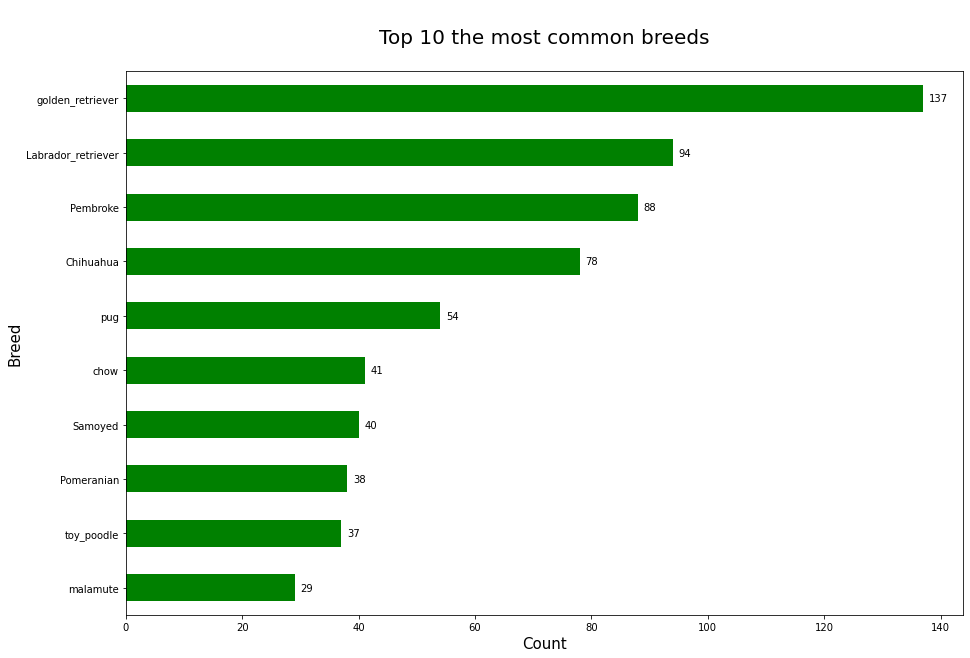

In [85]:
# Plot most common 10 breeds:
plt.figure(figsize=(15,10))
df_twitter['breed'].value_counts()[0:10].sort_values(ascending=True).plot(kind='barh' , color ='green')

# Set x_label, y_label and title:
plt.xlabel('Count',size=15)
plt.ylabel('Breed', size=15)
plt.title('\nTop 10 the most common breeds\n' , size=20)

# Set x & y positions to add text over each bar:
x = df_twitter['breed'].value_counts()[0:10].sort_values(ascending=True).values
y= np.arange(0,10,1)

# Add text (showing value) over each bar:
for xx, yy in zip(x,y):
    plt.text(xx+1,yy,xx , va='center')

### ```Most Common dog stages```

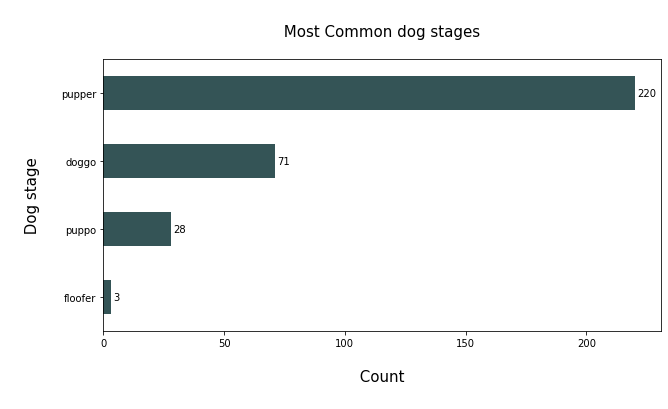

In [86]:
plt.rcParams["figure.figsize"] = [10, 5]
df_twitter['dog_stage'].value_counts().sort_values(ascending=True).plot(kind='barh' , color ='#345456')

# Set x_label, y_label and title:
plt.xlabel('\n Count \n',size=15)
plt.ylabel('\n Dog stage \n', size=15)
plt.title('\n Most Common dog stages \n' , size=15)

# Set x & y positions to add text over each bar:
x = df_twitter['dog_stage'].value_counts()[0:10].sort_values(ascending=True).values
y= np.arange(0,10,1)

# Add text (showing value) over each bar:
for xx, yy in zip(x,y):
    plt.text(xx+1,yy,xx , va='center')

### ```Tweet count perYear,month, timestamp```

Text(0.5, 1.0, '\n Tweet count perYear \n')

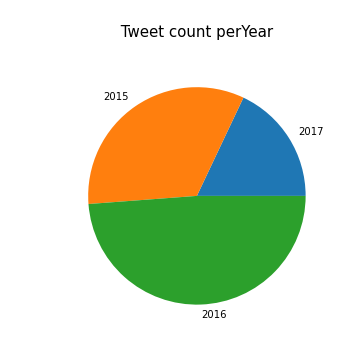

In [87]:
plt.rcParams["figure.figsize"] = [10, 5]
df_twitter['year'].value_counts().sort_values(ascending=True).plot(kind='pie')

# Set x_label, y_label and title:
plt.xlabel('\n\n',size=15)
plt.ylabel('\n \n', size=15)
plt.title('\n Tweet count perYear \n' , size=15)

# # Set x & y positions to add text over each bar:
# x = df_twitter['year'].value_counts()[0:10].sort_values(ascending=True).values
# y= np.arange(0,10,1)

# # Add text (showing value) over each bar:
# for xx, yy in zip(x,y):
#     plt.text(xx+1,yy,xx , va='center')

### ```word cloud for pupper```

In [88]:
df_twitter_sub = df_twitter.query('dog_stage == "pupper"')

In [89]:
stop_words = ["\n"] + list(STOPWORDS)

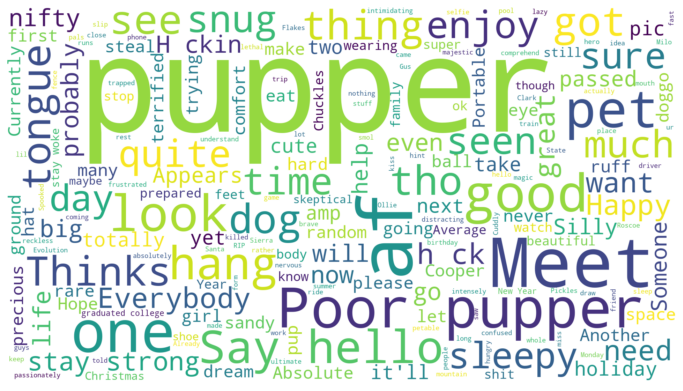

In [90]:
# word cloud for pupper

plt.subplots(figsize=(12,8))
wordcloud = WordCloud(
                          stopwords = stop_words,
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(str(item) for item in df_twitter_sub["text"]))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### ```Retweet and Favourite Trend```

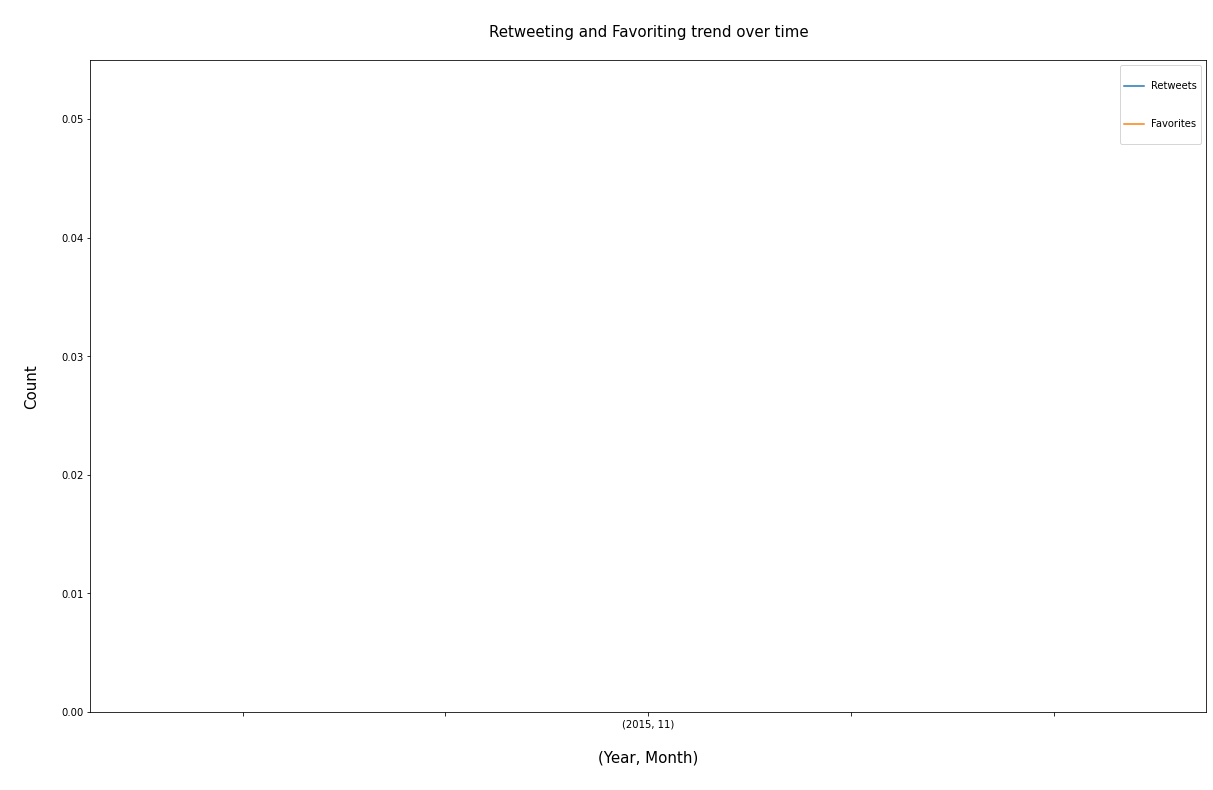

In [97]:
plt.subplots(1, sharex=True)
df_twitter.retweet_count.groupby([df_twitter["timestamp"].dt.year, df_twitter["timestamp"].dt.month]).mean().plot(kind = 'line')
df_twitter.favorite_count.groupby([df_twitter["timestamp"].dt.year, df_twitter["timestamp"].dt.month]).mean().plot(kind = 'line').set_ylim(0, )
plt.title('\nRetweeting and Favoriting trend over time\n', size =15)
plt.ylabel('\nCount\n', size =15)
plt.xlabel('\n(Year, Month)\n', size =15)
plt.legend(('\nRetweets\n', '\nFavorites\n'))
plt.savefig('ret_fav')

### ```Wordcloud for the different names of dogs```

In [92]:
stop =  ["none"] + list(STOPWORDS)

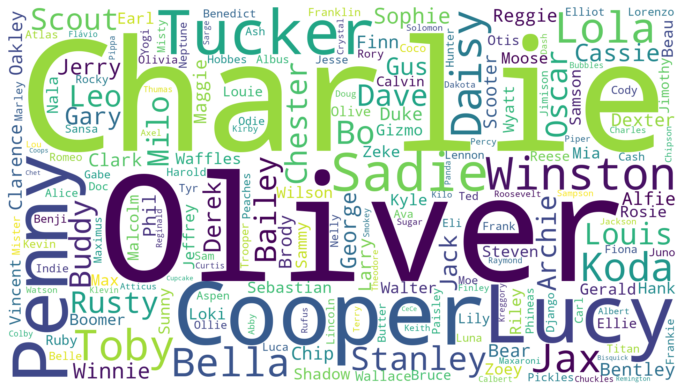

In [93]:
# word cloud for names 

plt.subplots(figsize=(12,8))
wordcloud = WordCloud(
                          stopwords = stop,
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(str(item) for item in df_twitter["dog_name"]))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### ```Word Cloud of texts```

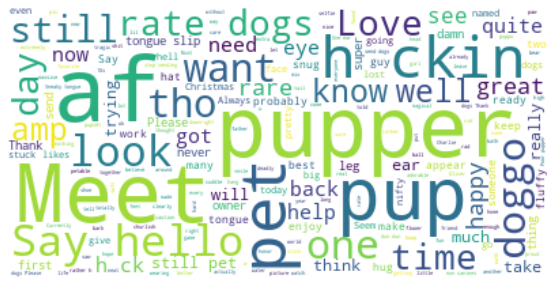

In [94]:
#Word Cloud of texts

text1 = " ".join(review for review in df_twitter.text) #to collect all texts from column 'text' in df_twitter
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["puppy", "Bruno", "dog", "good", "boy", 'cool'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text1)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### ```Dog Rating distribution```

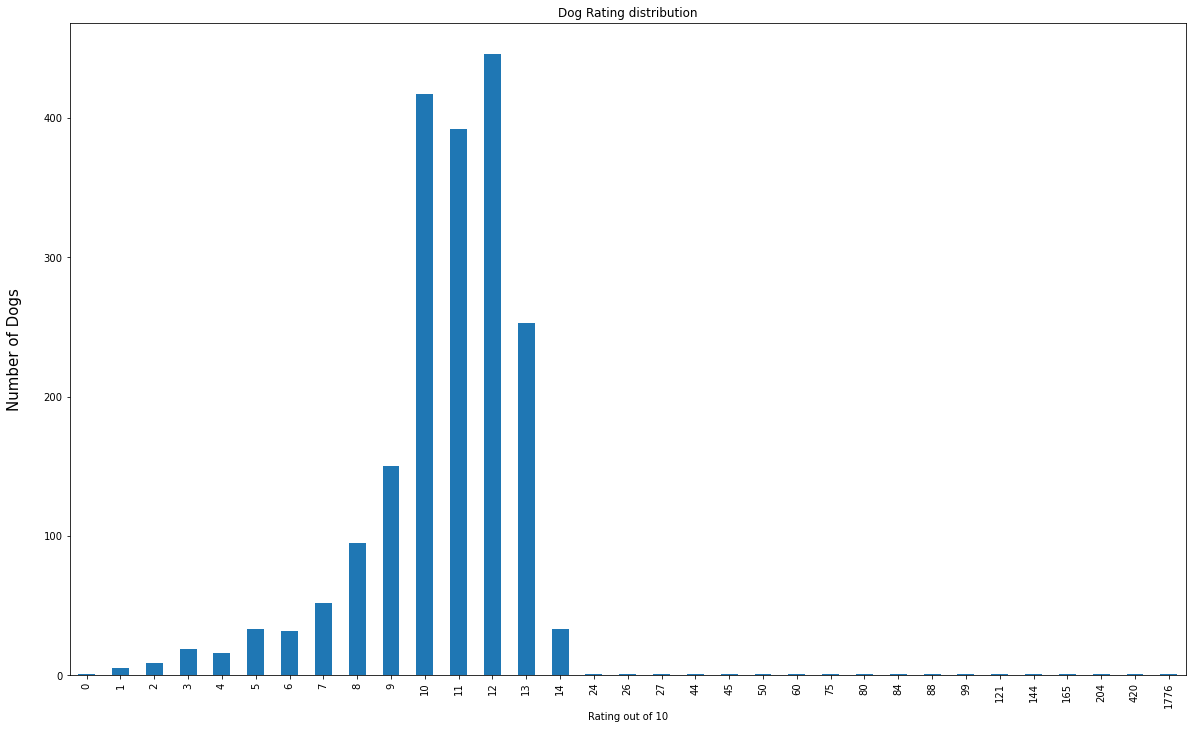

In [95]:
plt.rcParams["figure.figsize"] = [20, 12]
ax = df_twitter.rating_numerator.value_counts().sort_index().plot(kind = 'bar', title = 'Dog Rating distribution')
ax.set_xlabel("Rating out of 10")
ax.set_ylabel("Number of Dogs\n", size = 15)
plt.savefig('rating_dist')

### ```Resources``` <br>
> Unique rating system: http://knowyourmeme.com/memes/theyre-good-dogs-brent <br>
Plagiarism Tweet: https://t.co/YbEJPkg4Ag <br>
No dog in picture tweet: https://t.co/Asgdc6kuLX <br>
https://www.geeksforgeeks.org/removing-stop-words-nltk-python/ <br>
https://blog.rjmetrics.com/2017/04/13/an-export-api-walkthrough-with-python/ <br>
https://towardsdatascience.com/creating-a-dataset-using-an-api-with-python-dcc1607616d

## ```CONCLUSIONS```
> ```PUPPER because of it's stats has been shown to be the most loved dog by twitter dog lovers.```

> ```The most common breed is the golden-retriever```

> ```Most common dog names are Oliver, Cooper and Charlie```

> ```2016 ranks the highest tweet per year```

> ```november 2015 ranks the highest number of tweet in a single month```  <br>

>  ```while 2016 ranks the highest tweet in a year``` <br>

>  ```December ranks the highest cummulative tweet in a month``` <br>

>```Out of a total of all dogs rated by WeRateDogs, a total of 1142 dogs were rated above 10. However, only 33 were rated the highest (14) (excluding the ratings of the outliers).```

>``` out of a total of 1971 recorded breeds, golden_retriever ranks the highest dog breed recorded ``` <br>